# IBM Capstone Notebook

#### *Stuart McGill's Project for the Coursera Applied Data Science Capstone Course*

## Assignment 1

The purpose of this notebook is to fulfil the requirements of the Coursera Applied Data Science Capstone Course.

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
print("Hello Capstone Project Course!")

## Assignment 2: Segmenting and Clustering Neighborhoods in Toronto

In [ ]:
import requests

import folium

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors 

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram

**Part 1: Scraping post code data from Wikipedia**

Pandas is used to read the postcode data from Wikipedia

In [ ]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
canada_postcodes = pd.read_html(url)[0]
canada_postcodes.head()


Removing rows where the Borough is not assigned

In [ ]:
canada_postcodes = canada_postcodes[ canada_postcodes['Borough'] != 'Not assigned']
canada_postcodes.head(10)


Renaming neighborhoods that are not assigned with borough

In [ ]:
no_neighborhood_index =  canada_postcodes['Neighborhood'] == 'Not assigned'
canada_postcodes.loc[no_neighborhood_index,'Neighborhood'] = canada_postcodes[no_neighborhood_index]['Borough']
canada_postcodes[no_neighborhood_index]

Combining rows with the same borough and neighborhood so that the combined neighborhood is a string with each individual neighborhood separated by comma

In [ ]:
can_post_df = canada_postcodes.groupby(['Postcode', 'Borough']).aggregate({'Neighborhood':','.join}).reset_index()
can_post_df.head()

In [ ]:
print(can_post_df.shape)

#### Part 2: Getting latitude and longitude for Postcodes

Load latitude and longitude data from website

In [ ]:
lat_long_df = pd.read_csv('https://cocl.us/Geospatial_data')


Prepare location data for merging with postcode dataframe

In [ ]:
lat_long_df.rename(columns={'Postal Code':'Postcode'},inplace=True)
lat_long_df.set_index('Postcode',inplace=True)
lat_long_df.head()

In [ ]:
can_post_lat_df = can_post_df.join(lat_long_df, on='Postcode')
can_post_lat_df.head()


#### Part 3: Toronto Clustering Exploration 

Get all rows with borough containing Toronto

In [ ]:
toronto_lat_df = can_post_lat_df[ can_post_lat_df['Borough'].apply(lambda x : x.find('Toronto') != -1)]


To cluster the neighborhoods we need to get data that allows us to compare how similar each neighborhood are to one another. One way to measure neighborhood similarity is to compare distribution of cafes, restaurants, gyms and other facilities/venues. 

We can use Foursquare API to get venues within a 1000 metre radius of each neighborhood:

In [490]:
client_id = '' 
client_secret =   ''
version = '20180604'
limit = 100
radius = 1000 
lat = 43.676357
lng = -79.293031


In [320]:


def get_neighborhood_venues(name, lat, lng, client_id, client_secret, version, limit, radius):

    url_root = 'https://api.foursquare.com/v2/venues/explore?'
    url_pattern = 'client_id={}&client_secret={}&v={}&ll={:.2f},{:.2f}&limit={}&radius={}'
    full_url = url_root + url_pattern.format( client_id, client_secret, version, lat, lng, limit, radius)
    
    results = requests.get(full_url).json()["response"]['groups'][0]['items']
    
    venues = [(name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results]
    return venues
    

    
def get_all_neigh_vens(data, client_id, client_secret, version, limit, radius):
    
    venues_list = []
    for name, lat, lng in data[['Neighborhood', 'Latitude', 'Longitude']].values:
        print( name, lat, lng)
        venues = get_neighborhood_venues(name, lat, lng, client_id, client_secret, version, limit, radius)
        venues_list.append( venues)
        
    return venues_list

In [207]:

ven_list = get_all_neigh_vens(toronto_lat_df, client_id, client_secret, version, limit, radius)


The Beaches 43.67635739999999 -79.2930312
The Danforth West,Riverdale 43.6795571 -79.352188
The Beaches West,India Bazaar 43.6689985 -79.31557159999998
Studio District 43.6595255 -79.340923
Lawrence Park 43.7280205 -79.3887901
Davisville North 43.7127511 -79.3901975
North Toronto West 43.7153834 -79.40567840000001
Davisville 43.7043244 -79.3887901
Moore Park,Summerhill East 43.6895743 -79.38315990000001
Deer Park,Forest Hill SE,Rathnelly,South Hill,Summerhill West 43.68641229999999 -79.4000493
Rosedale 43.6795626 -79.37752940000001
Cabbagetown,St. James Town 43.667967 -79.3676753
Church and Wellesley 43.6658599 -79.38315990000001
Harbourfront 43.6542599 -79.3606359
Ryerson,Garden District 43.6571618 -79.37893709999999
St. James Town 43.6514939 -79.3754179
Berczy Park 43.644770799999996 -79.3733064
Central Bay Street 43.6579524 -79.3873826
Adelaide,King,Richmond 43.65057120000001 -79.3845675
Harbourfront East,Toronto Islands,Union Station 43.6408157 -79.38175229999999
Design Exchange,To

In [208]:
venues_df = pd.DataFrame( [item for venue_list in ven_list for item in venue_list], columns = ['Neighborhood', 'Neighborhood Lat',
                                                      'Neighborhood Lng', 'Venue', 'Venue Lat', 
                                                      'Venue Lng', 'Venue Category'])

In [209]:
venues_df

,Neighborhood,Neighborhood Lat,Neighborhood Lng,Venue,Venue Lat,Venue Lng,Venue Category
0,The Beaches,43.676357,-79.293031,The Beech Tree,43.680493,-79.288846,Gastropub
1,The Beaches,43.676357,-79.293031,Beaches Bake Shop,43.680363,-79.289692,Bakery
2,The Beaches,43.676357,-79.293031,The Feathers Pub,43.680570,-79.287473,Pub
3,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
4,The Beaches,43.676357,-79.293031,The Fox Theatre,43.672801,-79.287272,Indie Movie Theater
...,...,...,...,...,...,...,...
3142,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,Breakfast Club,43.662811,-79.310174,Breakfast Spot
3143,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,Carters Landing,43.662414,-79.309898,Bistro
3144,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,It's the Icing on the Cake,43.663453,-79.329813,Bakery
3145,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,TTC Stop #03057,43.663314,-79.330099,Light Rail Station


In [210]:
venues_df.groupby('Neighborhood').count()

,Neighborhood Lat,Neighborhood Lng,Venue,Venue Lat,Venue Lng,Venue Category
Neighborhood,,,,,,
"Adelaide,King,Richmond",100,100,100,100,100,100
Berczy Park,99,99,99,99,99,99
"Brockton,Exhibition Place,Parkdale Village",100,100,100,100,100,100
Business Reply Mail Processing Centre 969 Eastern,72,72,72,72,72,72
"CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara",19,19,19,19,19,19
"Cabbagetown,St. James Town",100,100,100,100,100,100
Central Bay Street,100,100,100,100,100,100
"Chinatown,Grange Park,Kensington Market",100,100,100,100,100,100
Christie,100,100,100,100,100,100


In [213]:
num_cat = len(venues_df['Venue Category'].unique())

print('There are {} unique veunue categories in the Toronto data'.format(num_cat))

There are 286 unique veunue categories in the Toronto data


Now the venue data has been combined with the neighborhoods, the frequency of each unique venue category for each neighborhood is used as features for Kmeans clustering. To do this we first encode each feature by a *one hot* matrix:

In [232]:
one_hot_venues = pd.get_dummies(venues_df['Venue Category'], prefix= '', prefix_sep = '')
one_hot_venues['Neighborhood'] = venues_df['Neighborhood']
neigh_ind = list(one_hot_venues.columns).index('Neighborhood')
fixed_columns = [one_hot_venues.columns[neigh_ind]] + list(one_hot_venues.columns[:neigh_ind]) + list(one_hot_venues.columns[neigh_ind+1:])
one_hot_venues = one_hot_venues[fixed_columns]
one_hot_venues.head()

,Neighborhood,Accessories Store,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,...,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Then the mean of the *one hot* matrix is calculated by grouping rows based on neighborhood:

In [235]:
toronto_grouped = one_hot_venues.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Accessories Store,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,...,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,"Adelaide,King,Richmond",0.00,0.000000,0.000000,0.020000,0.000000,0.00,0.00000,0.00,0.010000,...,0.020000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.01,0.000000,0.000000
1,Berczy Park,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00000,0.00,0.010101,...,0.010101,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000
2,"Brockton,Exhibition Place,Parkdale Village",0.01,0.000000,0.000000,0.010000,0.000000,0.00,0.00000,0.00,0.010000,...,0.020000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000
3,Business Reply Mail Processing Centre 969 Eastern,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00000,0.00,0.000000,...,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000
4,"CN Tower,Bathurst Quay,Island airport,Harbourf...",0.00,0.052632,0.052632,0.000000,0.000000,0.00,0.00000,0.00,0.000000,...,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.052632,0.000000
5,"Cabbagetown,St. James Town",0.00,0.000000,0.000000,0.010000,0.000000,0.00,0.00000,0.00,0.000000,...,0.000000,0.00,0.000000,0.00,0.000000,0.01,0.000000,0.00,0.000000,0.000000
6,Central Bay Street,0.00,0.000000,0.000000,0.010000,0.000000,0.00,0.00000,0.00,0.020000,...,0.010000,0.00,0.020000,0.00,0.000000,0.00,0.000000,0.00,0.010000,0.000000
7,"Chinatown,Grange Park,Kensington Market",0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00000,0.00,0.010000,...,0.030000,0.00,0.020000,0.00,0.010000,0.00,0.000000,0.00,0.030000,0.000000
8,Christie,0.00,0.000000,0.000000,0.010000,0.000000,0.00,0.00000,0.00,0.010000,...,0.020000,0.02,0.010000,0.00,0.010000,0.00,0.000000,0.00,0.000000,0.000000
9,Church and Wellesley,0.00,0.000000,0.000000,0.010000,0.000000,0.00,0.00000,0.00,0.000000,...,0.010000,0.01,0.000000,0.00,0.000000,0.01,0.000000,0.01,0.010000,0.000000


To check the validity of clustering a dataframe containing the top 10 most common venues for each neighborhood is created:

In [236]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

For k-Means clustering the number of clusters needs to be determined. One way to do this is to repeatedly cluster the data with different numbers of cluster, score each clustering, take the mean score for each cluster, then select the cluster number with the lowest score:

Text(0, 0.5, 'Cluster Score')

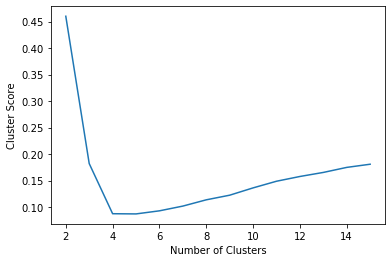

In [319]:
# Estimate number of clusters
cluster_nums = list(range(2,16))
all_scores = []
for i in range(100):
    scores = []
    for kclusters in cluster_nums:

        toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

        # run k-means clustering
        kmeans = KMeans(n_clusters=kclusters).fit(toronto_grouped_clustering)

        score = metrics.silhouette_score(toronto_grouped_clustering, kmeans.labels_) 
        scores.append(score)
    all_scores.append(scores)


plt.plot(cluster_nums, np.mean(all_scores,axis=0))
plt.xlabel('Number of Clusters')
plt.ylabel('Cluster Score')

In [473]:
cluster_score = min(np.mean(all_scores,axis=0))
cluster_number = np.nonzero( cluster_score == np.mean(all_scores,axis=0))[0][0] +2

print('Best cluster number: {}, score {:.3f}'.format(cluster_number, cluster_score))

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

   

Best cluster number: 5, score 0.087


The next part is to get an idea of what each cluster shares in common. So the top 10 venues for each neighborhood are determined :

In [401]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd'] 

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    if ind < len(indicators):
        abreviation = indicators[ind]
    else:
        abreviation = 'th'
    columns.append('{}{} Most Common Venue'.format(ind+1, abreviation))


# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)


neighborhoods_venues_sorted.head()


,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,4,"Adelaide,King,Richmond",Coffee Shop,Café,Restaurant,Hotel,Gastropub,Cosmetics Shop,Japanese Restaurant,Steakhouse,Gym,Concert Hall
1,2,Berczy Park,Coffee Shop,Boat or Ferry,Sporting Goods Shop,Pizza Place,Park,Bar,Farmers Market,Seafood Restaurant,Cocktail Bar,Steakhouse
2,1,"Brockton,Exhibition Place,Parkdale Village",Café,Bar,Coffee Shop,Restaurant,Furniture / Home Store,Tibetan Restaurant,Bakery,Flower Shop,Indian Restaurant,Beer Bar
3,1,Business Reply Mail Processing Centre 969 Eastern,Park,Fast Food Restaurant,Pizza Place,Harbor / Marina,Bar,Bakery,Coffee Shop,Light Rail Station,Italian Restaurant,Burrito Place
4,1,"CN Tower,Bathurst Quay,Island airport,Harbourf...",Park,Café,Harbor / Marina,Seafood Restaurant,Sculpture Garden,Track,Brewery,Boat or Ferry,Scenic Lookout,Gym


In [399]:

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', best_kmeans.labels_)

toronto_merged = toronto_lat_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,M4E,East Toronto,The Beaches,43.676357,-79.293031,2,Coffee Shop,Pub,Breakfast Spot,Grocery Store,Pizza Place,Caribbean Restaurant,Indian Restaurant,Gastropub,Gas Station,Sporting Goods Shop
41,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188,4,Greek Restaurant,Coffee Shop,Café,Pub,Italian Restaurant,Spa,Ice Cream Shop,Bakery,Yoga Studio,Burger Joint
42,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572,1,Indian Restaurant,Café,Pizza Place,Park,Brewery,Restaurant,Light Rail Station,Fast Food Restaurant,Pub,Burrito Place
43,M4M,East Toronto,Studio District,43.659526,-79.340923,1,Coffee Shop,Bar,Café,Bakery,Brewery,Italian Restaurant,American Restaurant,Diner,French Restaurant,Sushi Restaurant
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Bus Line,Bookstore,Gym / Fitness Center,Restaurant,Trail,Coffee Shop,Lawyer,College Quad,Park,Pool


Next the k-means clustering is visualised:

In [475]:
# create map
kmeans = KMeans(n_clusters=cluster_number).fit(toronto_grouped_clustering)
toronto_merged['Cluster Labels'] = kmeans.labels_

map_clusters = folium.Map(location=[lat, lng], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

However, atfer running several times it was clear that k-means clustering was not very consistent on this data set due to its random start state. So as an alternative, agglorerative clustering was used to first inspect the similarity between neighborhoods with the dendrogram plot:

In [471]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)








Text(0.5, 0, 'Number of points in node (or index of point if no parenthesis).')

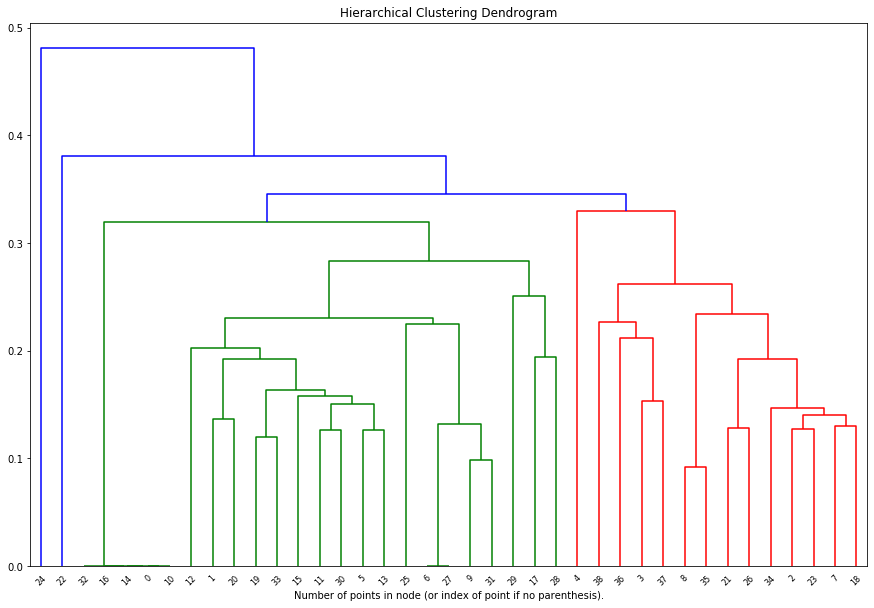

In [472]:

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(toronto_grouped_clustering)
plt.figure(figsize=(15,10))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=30)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")

From the dentrogram plot it looked like 6 clusters would be better than the k-means 5, with 3 venues in separeate clusters (24, 22, and 4)

In [476]:
model_1 = AgglomerativeClustering(distance_threshold=None, n_clusters=6)
model_1.fit(X)


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=6)

In [478]:

toronto_merged['Cluster Labels'] = model_1.labels_

map_clusters = folium.Map(location=[lat, lng], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Each cluster was then inspected to assess its defining qualities.

Cluster 1: Mostly made up of restaurants and cafes

In [483]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,"The Danforth West,Riverdale",0,Greek Restaurant,Coffee Shop,Café,Pub,Italian Restaurant,Spa,Ice Cream Shop,Bakery,Yoga Studio,Burger Joint
45,Davisville North,0,Coffee Shop,Italian Restaurant,Park,Café,Dessert Shop,Supermarket,Bookstore,Food & Drink Shop,Tea Room,Taco Place
46,North Toronto West,0,Coffee Shop,Cosmetics Shop,Sporting Goods Shop,Clothing Store,Burger Joint,Metro Station,Food & Drink Shop,Bridal Shop,Spa,Flower Shop
49,"Deer Park,Forest Hill SE,Rathnelly,South Hill,...",0,Coffee Shop,Pub,Italian Restaurant,Sushi Restaurant,Sandwich Place,Bagel Shop,Café,Pizza Place,Japanese Restaurant,Thai Restaurant
51,"Cabbagetown,St. James Town",0,Coffee Shop,Restaurant,Park,Grocery Store,Café,Breakfast Spot,Pub,Pizza Place,Japanese Restaurant,Pharmacy
52,Church and Wellesley,0,Coffee Shop,Italian Restaurant,Japanese Restaurant,Café,Gym,Men's Store,Diner,Salon / Barbershop,Caribbean Restaurant,Hotel
53,Harbourfront,0,Coffee Shop,Park,Café,Bakery,Pub,Breakfast Spot,Theater,Farmers Market,Mexican Restaurant,Cheese Shop
55,St. James Town,0,Coffee Shop,Café,Restaurant,Hotel,Gastropub,Cosmetics Shop,Japanese Restaurant,Steakhouse,Gym,Concert Hall
57,Central Bay Street,0,Coffee Shop,Japanese Restaurant,Tea Room,Park,Gastropub,Bubble Tea Shop,Burger Joint,Ramen Restaurant,Bar,Thai Restaurant
59,"Harbourfront East,Toronto Islands,Union Station",0,Hotel,Coffee Shop,Café,Restaurant,Park,Aquarium,Japanese Restaurant,Brewery,Scenic Lookout,Deli / Bodega


Cluster 2: Mostly made up of coffee shops, restaurants and Gyms

In [485]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
42,"The Beaches West,India Bazaar",1,Indian Restaurant,Café,Pizza Place,Park,Brewery,Restaurant,Light Rail Station,Fast Food Restaurant,Pub,Burrito Place
43,Studio District,1,Coffee Shop,Bar,Café,Bakery,Brewery,Italian Restaurant,American Restaurant,Diner,French Restaurant,Sushi Restaurant
47,Davisville,1,Coffee Shop,Italian Restaurant,Pizza Place,Sushi Restaurant,Gym,Café,Gastropub,Sandwich Place,Indian Restaurant,Dessert Shop
48,"Moore Park,Summerhill East",1,Park,Grocery Store,Trail,Playground,Thai Restaurant,Sandwich Place,Café,Cemetery,Gym,Candy Store
58,"Adelaide,King,Richmond",1,Coffee Shop,Café,Restaurant,Hotel,Gastropub,Cosmetics Shop,Japanese Restaurant,Steakhouse,Gym,Concert Hall
61,"Commerce Court,Victoria Hotel",1,Coffee Shop,Café,Restaurant,Hotel,Gastropub,Cosmetics Shop,Japanese Restaurant,Steakhouse,Gym,Concert Hall
64,"Forest Hill North,Forest Hill West",1,Park,Skating Rink,Gym / Fitness Center,Sushi Restaurant,Trail,Italian Restaurant,Coffee Shop,Japanese Restaurant,Deli / Bodega,Fast Food Restaurant
67,"Chinatown,Grange Park,Kensington Market",1,Coffee Shop,Café,Bar,Italian Restaurant,Bakery,Yoga Studio,Dessert Shop,Vegetarian / Vegan Restaurant,French Restaurant,Mexican Restaurant
82,"High Park,The Junction South",1,Café,Bar,Thai Restaurant,Convenience Store,Coffee Shop,Pizza Place,Italian Restaurant,Sushi Restaurant,Gym,Music Venue
83,"Parkdale,Roncesvalles",1,Pizza Place,Bar,Café,Pub,Breakfast Spot,Sushi Restaurant,Convenience Store,Gym,Coffee Shop,Restaurant


cluster 3: Mostly coffee shops, with some non-food shops and services (transport, sports)

In [486]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,The Beaches,2,Coffee Shop,Pub,Breakfast Spot,Grocery Store,Pizza Place,Caribbean Restaurant,Indian Restaurant,Gastropub,Gas Station,Sporting Goods Shop
50,Rosedale,2,Park,Coffee Shop,Grocery Store,Italian Restaurant,Bank,Beer Store,Sporting Goods Shop,Playground,Japanese Restaurant,Juice Bar
54,"Ryerson,Garden District",2,Coffee Shop,Italian Restaurant,Bookstore,Burger Joint,Tea Room,Japanese Restaurant,Theater,Park,Bubble Tea Shop,Burrito Place
56,Berczy Park,2,Coffee Shop,Boat or Ferry,Sporting Goods Shop,Pizza Place,Park,Bar,Farmers Market,Seafood Restaurant,Cocktail Bar,Steakhouse
77,"Little Portugal,Trinity",2,Bar,Café,Restaurant,Italian Restaurant,Bakery,Asian Restaurant,Vegetarian / Vegan Restaurant,Pizza Place,Coffee Shop,Cocktail Bar


Cluster 4: Mostly restaurants and cafe/coffee shops

In [487]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
65,"The Annex,North Midtown,Yorkville",3,Korean Restaurant,Café,Grocery Store,Vegetarian / Vegan Restaurant,Bakery,Coffee Shop,Japanese Restaurant,Pizza Place,Mexican Restaurant,Dessert Shop


Cluster 5: Mostly facilites (trasport)

In [488]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Lawrence Park,4,Bus Line,Bookstore,Gym / Fitness Center,Restaurant,Trail,Coffee Shop,Lawyer,College Quad,Park,Pool


Cluster 6: Skating rink and coffee with some other facilities

In [489]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Roselawn,5,Coffee Shop,Café,Sushi Restaurant,Pharmacy,Italian Restaurant,Bank,Skating Rink,Garden,Clothing Store,Lingerie Store
